# Regen plots

This notebook serves to try to make sense of and regenerate the plots Ben Evans made for this project. Once that's done I'll probably move to R and ggplot (and maybe ggplotly?) to make plots instead.

In [3]:
import os
import re
import sys
from collections import defaultdict
from glob import glob

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ete3 import BarChartFace, NodeStyle, RectFace, TextFace, Tree, TreeStyle
# Need to have PyQt5 installed as well: https://github.com/etetoolkit/ete/issues/354

from ete3.treeview.faces import add_face_to_node

os.environ["QT_QPA_PLATFORM"] = "offscreen"
outgroup = "K.CD.87.P3844.MH705156"
bootstrap_cutoff = 95


def add_support_and_subtypes(tree):
    for node in tree.traverse():
        if not node.is_leaf() and "/" in node.name:
            shalrt, bootstrap = [float(x) for x in node.name.split("/")]
            node.add_features(
                SHaLRT=shalrt,
                bootstrap=bootstrap,
                barchart_values=defaultdict(lambda: 0),
                suport_symbol="",
            )
            node.name = ""
        elif node.is_leaf():
            subtype = node.name.split('.',1)[0]
            node.add_features(
                subtype = subtype
            )


def get_support_symbol(ref_aln_bstrap, comp_aln_bstrap):
    if ref_aln_bstrap >= bootstrap_cutoff and comp_aln_bstrap >= bootstrap_cutoff:
        return "↗"
    elif ref_aln_bstrap >= bootstrap_cutoff and comp_aln_bstrap < bootstrap_cutoff:
        return "↘"
    elif ref_aln_bstrap < bootstrap_cutoff and comp_aln_bstrap >= bootstrap_cutoff:
        return "↖"
    elif ref_aln_bstrap < bootstrap_cutoff and comp_aln_bstrap < bootstrap_cutoff:
        return "↙"


Bad key "text.kerning_factor" on line 4 in
/Users/aguang/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
ref_tree_file = "../trees/HIV1_FLT_2018_genome_DNA.fa.treefile"
plot_prefix = "whole_v_masked"
ref_bs_label = "Whole Alignment Bootstrap"
tree_bs_label = "Masked Alignment Bootstrap"
tree_file_list = ["../trees/HIV1_FLT_2018_genome_DNA_mask100.fa.treefile"]
tree_orientation = 0
pct_masks = [0]

# Regen all

There are two options in `sys.argv` for the `bootstrap_support.py` script: `--all` and `--mask-as-ref`. So we'll try both here. This is for the `--all` option.

In [7]:
shared_edge_support_values[1]
ref_only_edge_support_values[0]

20.0

In [5]:
tree_file_list = [
        t for t in glob("../trees/HIV1_FLT_2018_genome_DNA_mask*.fa.treefile")
    ]
plot_prefix = "whole_v_allmasks"

ref_tree = Tree(ref_tree_file, format=1)
ref_tree.set_outgroup(outgroup)
add_support_and_subtypes(ref_tree)

mask_regex = r"mask(\d+)"

shared_edge_support_values = []
ref_only_edge_support_values = []
for tree_file in tree_file_list:
    pct_mask_match = re.search(r"mask(\d+)", tree_file)
    if pct_mask_match is not None:
        pct_mask = int(pct_mask_match.groups()[0])
    else:
        pct_mask = 0
    print("Adding {} bootstrap values to tree from {}...".format(tree_file, ref_tree_file))
    pct_masks.append(pct_mask)
    tree = Tree(tree_file, format=1)
    add_support_and_subtypes(tree)
    tree.set_outgroup(outgroup)
    comparison = ref_tree.compare(tree)
    print("{}/{} common/total edges, normRF {:0.2f} for {} vs {}".format(len(comparison["common_edges"]), len(comparison["source_edges"]), comparison["norm_rf"], tree_file, ref_tree_file ))
    for common_edge in comparison["common_edges"]:
        tree_node = tree.get_common_ancestor(common_edge)
        if hasattr(tree_node, "bootstrap"):
            ref_tree_node = ref_tree.get_common_ancestor(common_edge)
            ref_tree_node.barchart_values[pct_mask] = tree_node.bootstrap
            ref_tree_node.barchart_values[0] = ref_tree_node.bootstrap
            ref_tree_node.suport_symbol = get_support_symbol(
                ref_tree_node.bootstrap, tree_node.bootstrap
            )
            shared_edge_support_values.append(
                {
                    ref_bs_label: ref_tree_node.bootstrap,
                    tree_bs_label: tree_node.bootstrap,
                    "Percent Mask": pct_mask,
                }
            )
    for ref_only_edge in comparison["ref_edges"] - comparison["common_edges"]:
        node = ref_tree.get_common_ancestor(ref_only_edge)
        if hasattr(node, "bootstrap"):
            ref_only_edge_support_values.append(node.bootstrap)

    print("Done.")

Adding ../trees/HIV1_FLT_2018_genome_DNA_mask070.fa.treefile bootstrap values to tree from ../trees/HIV1_FLT_2018_genome_DNA.fa.treefile...
518/3859 common/total edges, normRF 0.87 for ../trees/HIV1_FLT_2018_genome_DNA_mask070.fa.treefile vs ../trees/HIV1_FLT_2018_genome_DNA.fa.treefile
Done.
Adding ../trees/HIV1_FLT_2018_genome_DNA_mask010.fa.treefile bootstrap values to tree from ../trees/HIV1_FLT_2018_genome_DNA.fa.treefile...
1210/3859 common/total edges, normRF 0.69 for ../trees/HIV1_FLT_2018_genome_DNA_mask010.fa.treefile vs ../trees/HIV1_FLT_2018_genome_DNA.fa.treefile
Done.
Adding ../trees/HIV1_FLT_2018_genome_DNA_mask060.fa.treefile bootstrap values to tree from ../trees/HIV1_FLT_2018_genome_DNA.fa.treefile...
532/3859 common/total edges, normRF 0.86 for ../trees/HIV1_FLT_2018_genome_DNA_mask060.fa.treefile vs ../trees/HIV1_FLT_2018_genome_DNA.fa.treefile
Done.
Adding ../trees/HIV1_FLT_2018_genome_DNA_mask040.fa.treefile bootstrap values to tree from ../trees/HIV1_FLT_2018_gen

In [2]:
bootstrap_cutoff

NameError: name 'bootstrap_cutoff' is not defined

Not sure why but this part of the code keeps killing the kernel.

In [9]:
# Make some colors

subtypes = ["A", "B", "C", "D", "F1", "F2", "G", "H", "J", "K"]
tab10_cmap = mpl.cm.get_cmap("tab10")
subtype_color_dict = dict(zip(subtypes, [mpl.colors.to_hex(x) for x in tab10_cmap(np.linspace(0,1,10))] ))

color_map = mpl.cm.get_cmap("cividis")
plot_colors = color_map([x / 100 for x in reversed(sorted(pct_masks))])
tree_colors = [mpl.colors.to_hex(x) for x in plot_colors]
scatter_colors = plot_colors

In [ ]:
# plot trees
# color monophyletic subtypes
print("Plotting trees...")
def color_subtypes(node):
    node_style = NodeStyle()
    node_style["hz_line_width"] = 2
    node_style["vt_line_width"] = 2
    if hasattr(node, "bootstrap"):
        if node.bootstrap >= bootstrap_cutoff:
            node_style["fgcolor"] = "black"

        else:
            node_style["fgcolor"] = "grey"
    else:
        node_style["fgcolor"] = "black"
    
    if hasattr(node, "subtype") and node.subtype in subtype_color_dict:
        node_style["hz_line_color"] = subtype_color_dict[node.subtype]
    else:
        # check for subtype monophyly and color if true
        subtypes = set()
        for leaf in node.get_leaves():
            subtypes.add(leaf.subtype)
            if len(subtypes) > 1:
                break
        subtype = subtypes.pop()
        if len(subtypes) == 0 and subtype in subtype_color_dict:
            node_style["vt_line_color"] = subtype_color_dict[subtype]
            node_style["hz_line_color"] = subtype_color_dict[subtype]
    return node_style

# add an arrow symbol pointing to the quadrant 
# this bootstrap comparison belongs in in scatter below
def botstrap_symbols(node):
    node_style = color_subtypes(node)
    if hasattr(node, "suport_symbol"):
        add_face_to_node(
            face=TextFace(node.suport_symbol),
            node=node,
            column=0,
        )
    node.set_style(node_style)

# call larger attention to lower right quadrant from scatter
# 
def botstrap_lower_right(node):
    node_style = color_subtypes(node)
    if hasattr(node, "suport_symbol"):
        if node.suport_symbol == "↘":
            node_style["size"] = 100
            node_style["fgcolor"] = "#66000000"

    node.set_style(node_style)


for output_string, mode, layout_fn in zip(["tree_symbols", "tree_symbols", "tree_arrows",], ["c", "r", "r"], [botstrap_lower_right, botstrap_lower_right, botstrap_symbols]):
    stars_style = TreeStyle()
    stars_style.layout_fn = layout_fn
    stars_style.orientation = tree_orientation
    stars_style.mode = mode
    for subtype in subtype_color_dict:
        stars_style.legend.add_face(RectFace(10,10, subtype_color_dict[subtype], subtype_color_dict[subtype]),column=0)
        stars_style.legend.add_face(TextFace(subtype, fgcolor=subtype_color_dict[subtype], bold=True),column=1)
    stars_style.legend_position = 2
    ref_tree.render(
        file_name="plots/{}_{}_{}.pdf".format(plot_prefix, output_string, mode), tree_style=stars_style
    )
print("Done.")

In [124]:
tmpdf = pd.DataFrame({'Bootstrap': shared_edge_df['Whole Alignment Bootstrap']})
tmpdf['Percent Mask'] = 0
tmpdf

tmpdf2 = pd.DataFrame(shared_edge_df[['Masked Alignment Bootstrap','Percent Mask']])
tmpdf2.rename(columns={'Masked Alignment Bootstrap':'Bootstrap'}, inplace=True)

heatmapdf = pd.concat([tmpdf,tmpdf2])

In [125]:
heatmapdf["bins"]=pd.cut(pd.concat([tmpdf,tmpdf2])['Bootstrap'], [0,10,20,30,40,50,60,70,80,90,95,96,97,98,99,100], include_lowest=True,
                        labels=[10,20,30,40,50,60,70,80,90,95,96,97,98,99,100])

In [126]:
heatmapdf = heatmapdf.value_counts(subset=["Percent Mask","bins"]).to_frame()

In [127]:
heatmapdf2 = np.log(heatmapdf)

In [138]:
heatmapdf_annot

Percent Mask,0,10,20,30,40,50,60,70,80,90,100
bins,,,,,,,,,,,
10,0,0,0,1,0,0,2,5,0,4,1
20,49,1,0,2,4,2,8,3,2,4,3
30,45,5,11,4,12,12,7,4,2,3,2
40,49,24,16,8,10,4,7,6,1,4,9
50,54,24,10,8,16,9,6,5,6,2,4
60,54,18,3,14,9,12,5,5,13,7,6
70,93,23,17,26,15,15,13,25,15,17,7
80,110,44,31,30,19,15,11,10,10,8,8
90,333,70,56,63,39,35,25,25,23,28,22


In [160]:
heatmapdf_sns = heatmapdf2.reset_index().pivot_table(index='bins',columns='Percent Mask',values=0, fill_value=0)
heatmapdf_annot = heatmapdf.reset_index().pivot_table(index='bins',columns='Percent Mask',values=0,fill_value=0)
fig, ax = plt.subplots(dpi=300)
p = sns.heatmap(heatmapdf_sns, annot=heatmapdf_annot, fmt="d",annot_kws={"fontsize":8})
p.set_ylabel("Bootstrap")
_,ylabels=plt.yticks()
p.set_yticklabels(ylabels,size=8)
plt.yticks(np.arange(15)+0.5,rotation=90,va="center")
p.set_title("Number of nodes with bootstrap per masking percentage")
p.tick_params(left=False,bottom=False)

# workaround from https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
#plt.show() # ta-da!
plt.tight_layout()
plt.savefig("../plots/{}_heatmap.png".format(plot_prefix))
plt.close()

In [87]:
pd.DataFrame(np.random.random((5,5)), columns=["a","b","c","d","e"])


,a,b,c,d,e
0,0.203022,0.619918,0.261828,0.350529,0.872082
1,0.614729,0.912605,0.045808,0.478181,0.450445
2,0.103024,0.549617,0.507100,0.597707,0.194233
3,0.927410,0.742053,0.619995,0.452118,0.576694
4,0.754561,0.320010,0.011489,0.646571,0.512710


In [ ]:
sns.heatmap(heatmapdf.value_counts().to_frame())

In [55]:
shared_edge_df[['Whole Alignment Bootstrap','Masked Alignment Bootstrap','Percent Mask']].value_counts()

IndexError: Inconsistent shape between the condition and the input (got (1652, 1) and (1652,))

In [6]:
# dataframe for bootstrap values plotting
shared_edge_df = pd.DataFrame(shared_edge_support_values)
# "top-right" of scatter plot
high_support_df = shared_edge_df[
    (shared_edge_df[ref_bs_label] >= bootstrap_cutoff)
    & (shared_edge_df[tree_bs_label] >= bootstrap_cutoff)
]
# "bottom-right" of scatter plot
ref_aln_support_df = shared_edge_df[
    (shared_edge_df[ref_bs_label] >= bootstrap_cutoff)
    & (shared_edge_df[tree_bs_label] < bootstrap_cutoff)
]
# "top-left" of scatter plot
other_aln_support_df = shared_edge_df[
    (shared_edge_df[ref_bs_label] < bootstrap_cutoff)
    & (shared_edge_df[tree_bs_label] >= bootstrap_cutoff)
]
# "bottom-left" of scatter plot
low_support_df = shared_edge_df[
    (shared_edge_df[ref_bs_label] < bootstrap_cutoff)
    & (shared_edge_df[tree_bs_label] < bootstrap_cutoff)
]

## Scatter plot

This makes the scatter plot with the color gradient as percentage masked. Want to try it with log10 scaling though want to keep the ticks.

In [145]:
# scatter plot
print("Plotting scatter...")
fig, ax = plt.subplots(dpi=300)
ax.set_facecolor("gainsboro")
xlabel = ref_bs_label
ylabel = tree_bs_label
scatter_pcts = shared_edge_df["Percent Mask"].unique()
scatter_pcts.sort()
for pct, color in zip(reversed(scatter_pcts), reversed(scatter_colors)):
    pct_df = shared_edge_df[shared_edge_df["Percent Mask"] == pct]
    ax.scatter(
        pct_df[xlabel],
        pct_df[ylabel],
        color=color,
        label="{}% masked".format(pct),
        alpha=0.4,
        edgecolors="none",
    )
line_styles = {"color": "black", "linestyle": "--"}
ax.axvline(bootstrap_cutoff, **line_styles)
ax.axhline(bootstrap_cutoff, **line_styles)

top_right_pct_nodes = high_support_df.shape[0] / shared_edge_df.shape[0] * 100
bottom_right_pct_nodes = ref_aln_support_df.shape[0] / shared_edge_df.shape[0] * 100
top_left_pct_nodes = other_aln_support_df.shape[0] / shared_edge_df.shape[0] * 100
bottom_left_pct_nodes = low_support_df.shape[0] / shared_edge_df.shape[0] * 100
ax.text(
    101, bootstrap_cutoff + 2, "{:.1f}%".format(top_right_pct_nodes)
)
ax.text(bootstrap_cutoff + 2, 2, "{:.1f}%".format(bottom_right_pct_nodes))
ax.text(2, bootstrap_cutoff + 2, "{:.1f}%".format(top_left_pct_nodes))
ax.text(2, 2, "{:.1f}%".format(bottom_left_pct_nodes))

# August additions
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim([0, 102])
ax.set_xlabel(xlabel)
ax.set_ylim([0, 102])
ax.set_ylabel(ylabel)

if len(scatter_pcts) >1:
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
plt.savefig("../plots/{}_bootstrap_scatter_test.png".format(plot_prefix))
plt.close()
print("Done.")
"""
# quick whole/pol hist
%run ./scripts/bootstrap_support.py
whole_aln = ref_only_edge_support_values
%run ./scripts/bootstrap_support.py --mask-as-ref
masked_aln = ref_only_edge_support_values
plt.close()
fig, ax = plt.subplots(dpi=300)
ax.hist([masked_aln, whole_aln], bins=np.arange(10,105,5), label=["pol", "whole"])
ax.set_xlabel("Bootstrap")
plt.legend()
plt.tight_layout()
plt.savefig("plots/wholevpol_hist.png")
"""


Plotting scatter...


/Users/aguang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/aguang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/aguang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


Done.


'\n# quick whole/pol hist\n%run ./scripts/bootstrap_support.py\nwhole_aln = ref_only_edge_support_values\n%run ./scripts/bootstrap_support.py --mask-as-ref\nmasked_aln = ref_only_edge_support_values\nplt.close()\nfig, ax = plt.subplots(dpi=300)\nax.hist([masked_aln, whole_aln], bins=np.arange(10,105,5), label=["pol", "whole"])\nax.set_xlabel("Bootstrap")\nplt.legend()\nplt.tight_layout()\nplt.savefig("plots/wholevpol_hist.png")\n'

In [28]:
range(shared_edge_df.shape[0])

range(0, 6846)

In [29]:
shared_edge_df['rowID'] = range(shared_edge_df.shape[0])

In [30]:
shared_edge_df

,Whole Alignment Bootstrap,Masked Alignment Bootstrap,Percent Mask,rowID
0,85.0,100.0,70,0
1,100.0,100.0,70,1
2,100.0,100.0,70,2
3,100.0,100.0,70,3
4,100.0,95.0,70,4
...,...,...,...,...
6841,100.0,95.0,90,6841
6842,100.0,97.0,90,6842
6843,100.0,100.0,90,6843
6844,100.0,99.0,90,6844


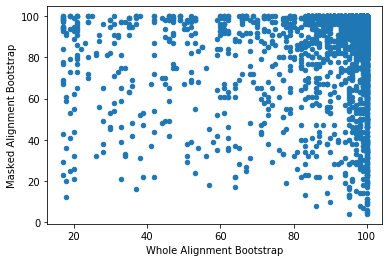

In [44]:
shared_edge_df.plot.scatter(x="Whole Alignment Bootstrap", y="Masked Alignment Bootstrap")

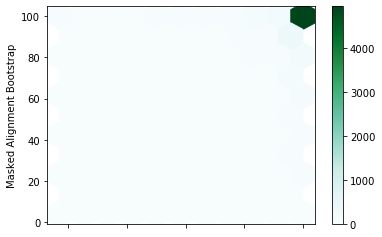

In [48]:
shared_edge_df.plot.hexbin(x="Whole Alignment Bootstrap", y="Masked Alignment Bootstrap", gridsize=10)

In [32]:
shared_edge_df2 = shared_edge_df.melt(id_vars=['Percent Mask','rowID'])

In [33]:
shared_edge_df2

,Percent Mask,rowID,variable,value
0,70,0,Whole Alignment Bootstrap,85.0
1,70,1,Whole Alignment Bootstrap,100.0
2,70,2,Whole Alignment Bootstrap,100.0
3,70,3,Whole Alignment Bootstrap,100.0
4,70,4,Whole Alignment Bootstrap,100.0
...,...,...,...,...
13687,90,6841,Masked Alignment Bootstrap,95.0
13688,90,6842,Masked Alignment Bootstrap,97.0
13689,90,6843,Masked Alignment Bootstrap,100.0
13690,90,6844,Masked Alignment Bootstrap,99.0


In [18]:
import seaborn as sns

/Users/aguang/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


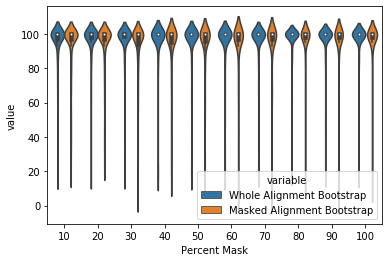

In [34]:
sns.violinplot(x="Percent Mask",y="value", hue="variable",data=shared_edge_df2)

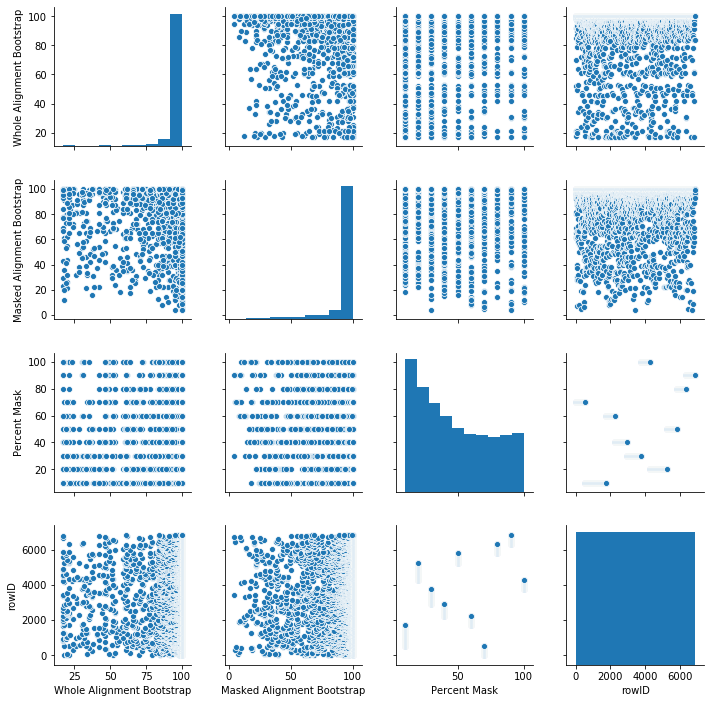

In [50]:
sns.pairplot(shared_edge_df)

In [39]:
people = np.repeat(("A","B","C","D","E"),5)
feature = list(range(1,6))*5
value = np.random.random(25)
df = pd.DataFrame({'feature': feature, 'people': people, 'value': value })
df_wide = df.pivot_table( index='people', columns='feature', values='value')

In [42]:
df

,feature,people,value
0,1,A,0.283032
1,2,A,0.297234
2,3,A,0.446928
3,4,A,0.634614
4,5,A,0.785575
5,1,B,0.223417
6,2,B,0.019041
7,3,B,0.485461
8,4,B,0.396934
9,5,B,0.387093


In [40]:
df_wide

feature,1,2,3,4,5
people,,,,,
A,0.283032,0.297234,0.446928,0.634614,0.785575
B,0.223417,0.019041,0.485461,0.396934,0.387093
C,0.474907,0.165213,0.118479,0.983486,0.036079
D,0.443413,0.534159,0.281955,0.494681,0.321526
E,0.482624,0.482157,0.881050,0.474452,0.404846


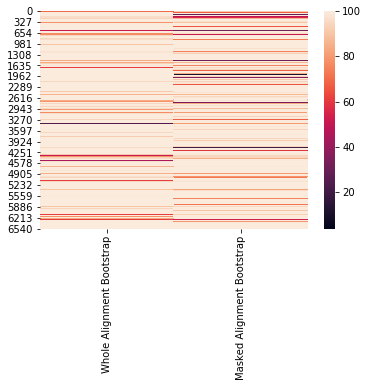

In [41]:
sns.heatmap(shared_edge_df[["Whole Alignment Bootstrap", "Masked Alignment Bootstrap"]])

Plotting histogram...


FileNotFoundError: [Errno 2] No such file or directory: 'plots/whole_v_allmasks_bootstrap_hist.png'

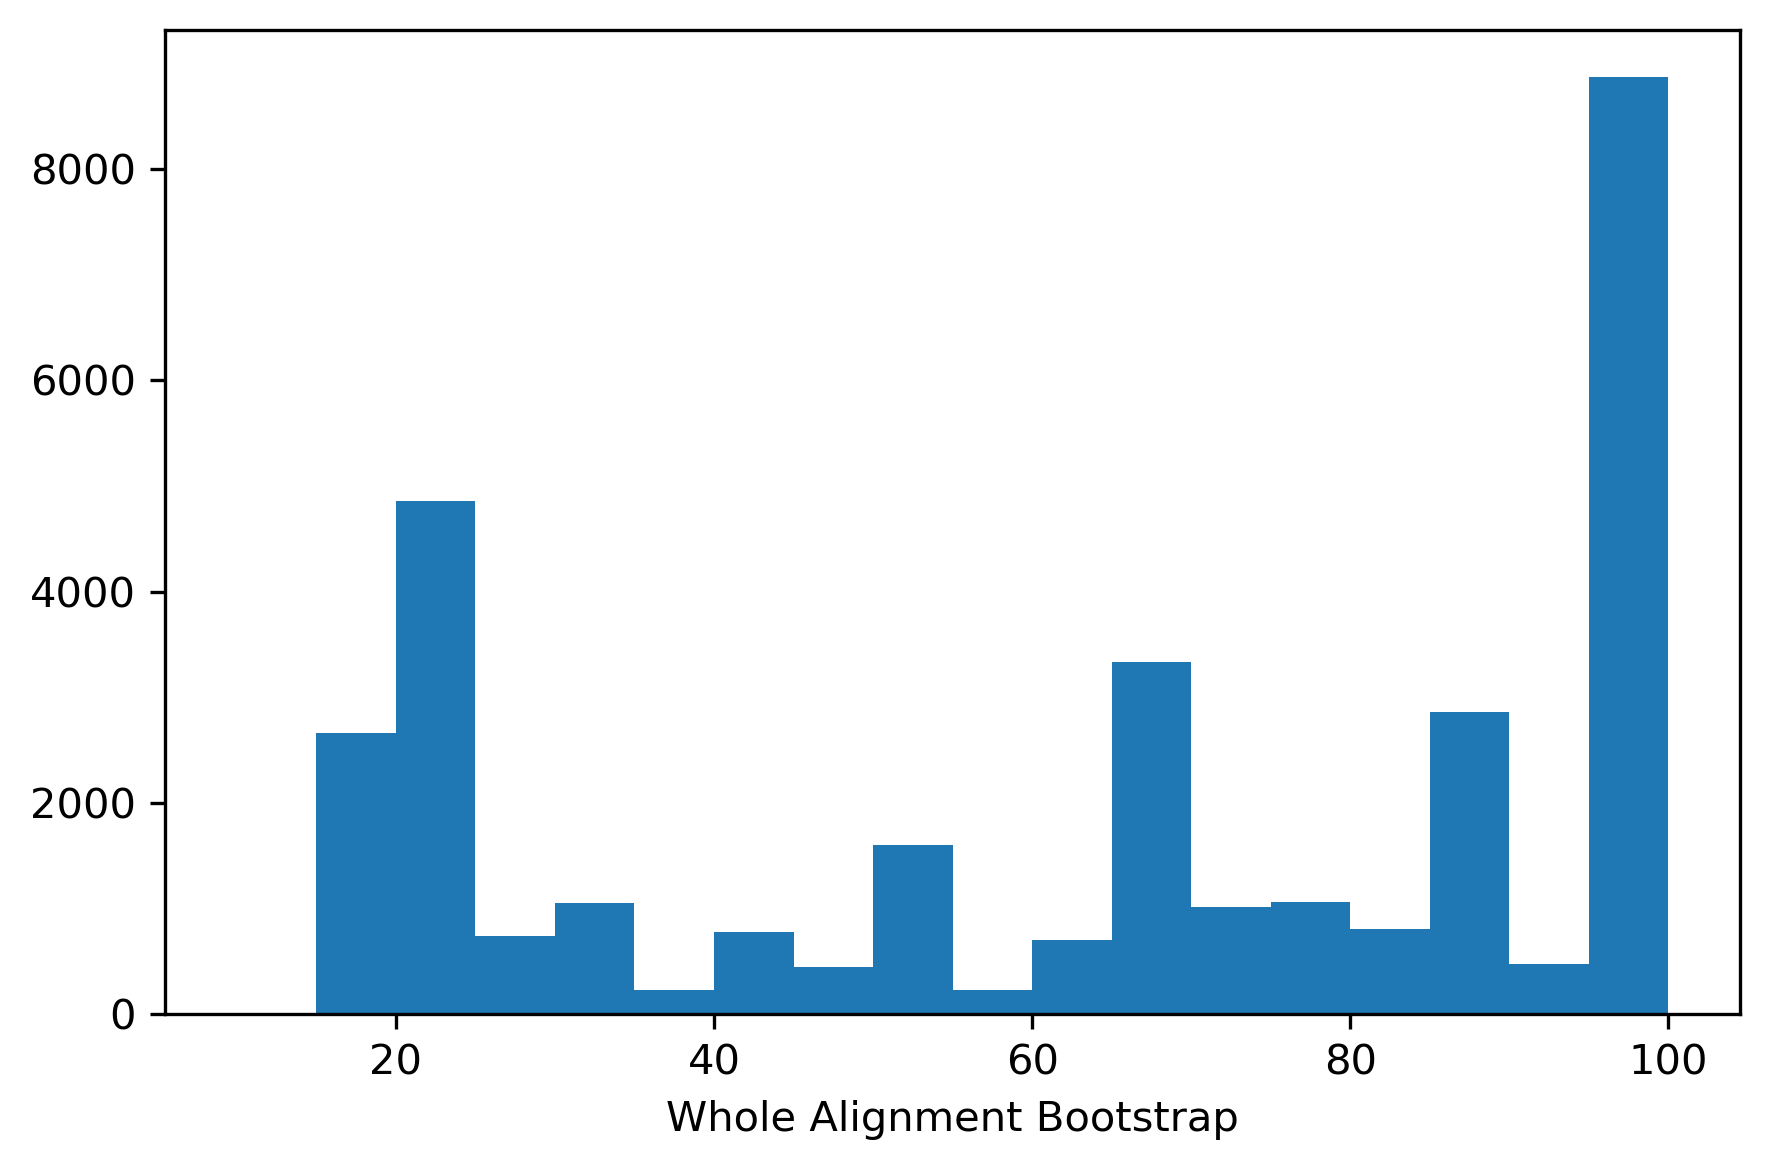

In [11]:
print("Plotting histogram...")
fig, ax = plt.subplots(dpi=300)
ax.hist(ref_only_edge_support_values, bins=np.arange(10,105,5))
ax.set_xlabel("{}".format(xlabel))
plt.tight_layout()
plt.savefig("plots/{}_bootstrap_hist.png".format(plot_prefix))
print("Done.")


# Mask-as-ref regen

In [ ]:

if "--mask-as-ref" in sys.argv:
    tree_file_list = [ref_tree_file]
    ref_tree_file = "trees/HIV1_FLT_2018_genome_DNA_mask100.fa.treefile"
    plot_prefix = "masked_v_whole"
    ref_bs_label = "Masked Alignment Bootstrap"
    tree_bs_label = "Whole Alignment Bootstrap"
    pct_masks = [100]
    tree_orientation = 1
